# Using an IMERG Event to Subset SSMIS/ATMS data from STARE-PODS

Michael Lee Rilee, mike@bayesics.com

First version: 2022-0529

In [1]:
import sys
sys.path.insert(0,'/homelocal/mrilee/git/pystareplotlib')

import os
os.environ['PROJ_LIB'] = '/homelocal/mrilee/opt/anaconda3/envs/stare-1/share/proj'

import pystare
import starepandas
import geopandas

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import cartopy
import cartopy.crs as ccrs

import pystareplotlib
import pystareplotlib.pystareplotlib as psplot

import numpy

import pickle
import datetime

plot_options = {'projection': ccrs.PlateCarree(central_longitude=0.0)
                ,'transform': ccrs.Geodetic()}

plot_options['projection']._threshold = 0.001;

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Some helper functions

def mnmx(x):
    return min(x),max(x)
def span(x):
    return max(x)-min(x)

class timings_store:
    def __init__(self):
        self.timings = {}
        return
   
    def add(self,key,value,verbose=True):
        self.timings[key] = value
        if verbose:
            print("{} {}".format(key,value))
        return self
    
    def print_report(self,fmt="{:30} {:>6.2f}",key=None,grepv=None):
        for i, (k,v) in enumerate(self.timings.items()):
            if key is None:
                if not grepv is None:
                    if not grepv in k:
                        print(fmt.format(k,v.total_seconds()))
                else:
                    print(fmt.format(k,v.total_seconds()))
            else:
                if key in k:
                    if not grepv is None:
                        if not grepv in k:
                            print(fmt.format(k,v.total_seconds()))
                    else:
                        print(fmt.format(k,v.total_seconds()))
        return self
    
timings = timings_store()

In [4]:
start = datetime.datetime.now()

In [5]:
data_dir = '/tablespace/xcal/'
with open(f'{data_dir}/pickles/featuredb.pickle', 'rb') as f:
    features = pickle.load( f)

# Load US States

In [6]:
states = geopandas.read_file('ignored/tl_2019_us_state.zip')

In [7]:
states = starepandas.STAREDataFrame(states)
sids = states.make_sids(n_workers=50, resolution=10)
states.set_sids(sids, inplace=True)
trixels = states.make_trixels(n_workers=50, wrap_lon=False)
states.set_trixels(trixels, inplace=True)
states.split_antimeridian(inplace=True)

In [8]:
roi_name = 'Virginia'
roi = states[states['NAME']==roi_name]
roi_sids = roi.sids.iloc[0]

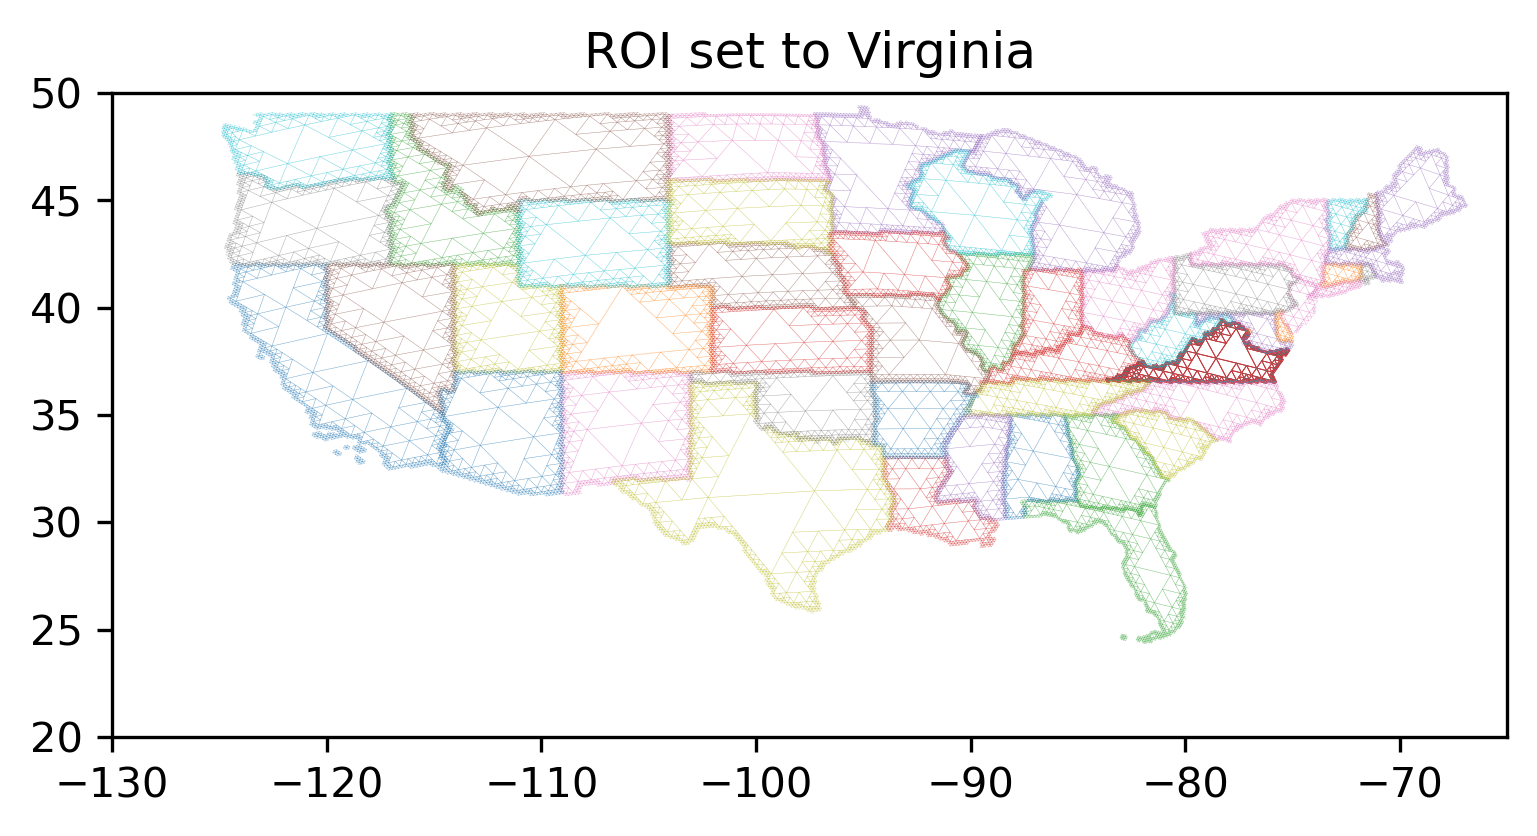

In [9]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot()

ax.set_xlim(-130, -65)
ax.set_ylim(20, 50)

roi.plot(ax=ax, linewidth=0.2, color='r')
states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4)

plt.title('ROI set to %s'%roi_name)
plt.show()

del fig,ax

# Pull out events intersecting the region of interest (ROI)

In [10]:
intersects = features.stare_intersects(roi_sids, n_workers=60)
features[intersects].label.unique()

array([17, 65, 79, 91, 94], dtype=int32)

# Inspecting the first event (17)

In [11]:
event_17 = features[features.label==17]

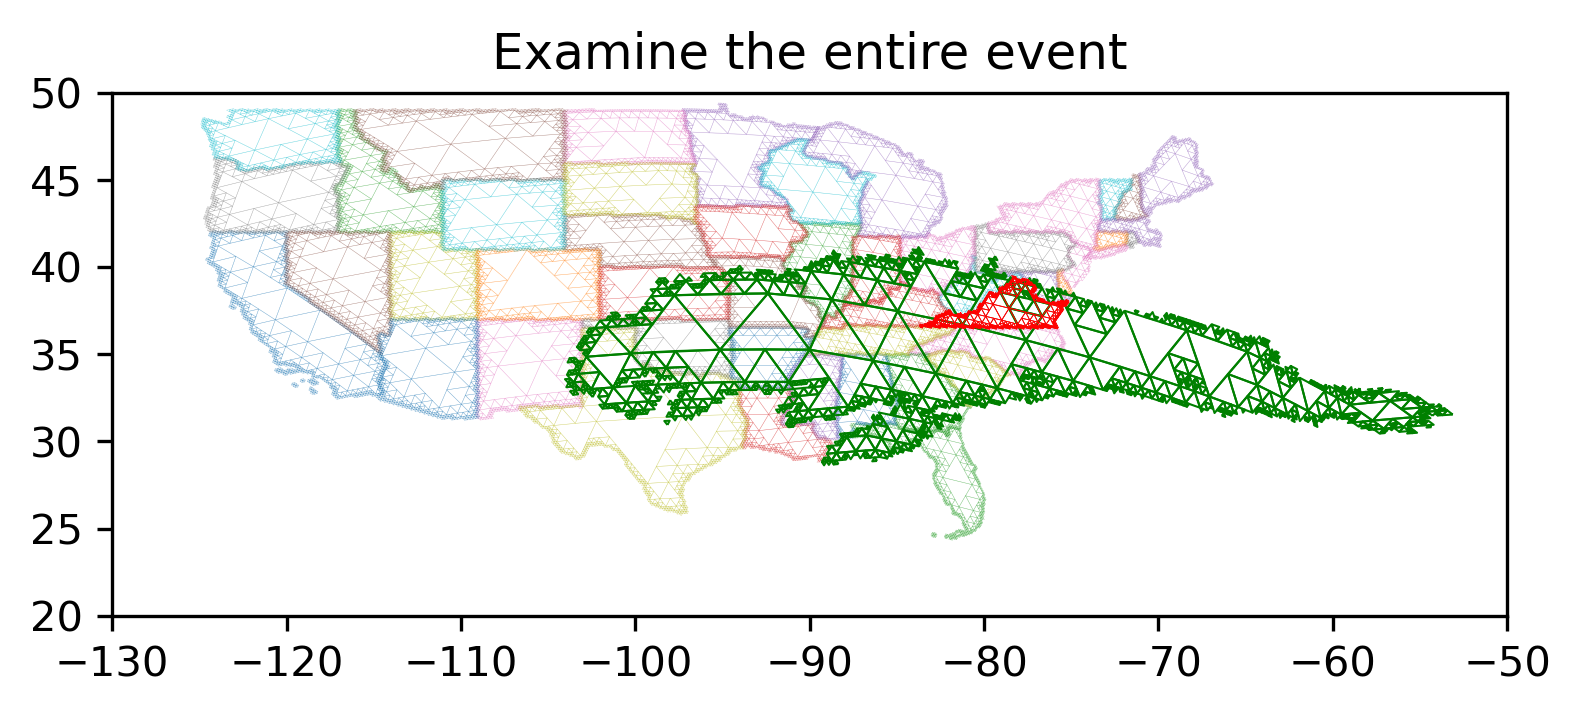

In [12]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot()

ax.set_xlim(-130, -65+15)
ax.set_ylim(20, 50)

states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4)

dissolved_sids = event_17.stare_dissolve()
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])

trixels = dissolved_event.make_trixels()
dissolved_event.set_trixels(trixels, inplace=True)

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='g')

event_17.plot(ax=ax, zorder=1, linewidth=0.1)

roi.plot(ax=ax, zorder=3, color='r', linewidth=0.2)

plt.title('Examine the entire event')
plt.show()

del fig,ax

# Calculating precip 

## Precip for the whole event

In [13]:
tot_precip = event_17.tot_precip.sum()
print(f'Total Precip: {tot_precip:,.2f} cubic meters')

Total Precip: 61,980,755,210.15 cubic meters


## Getting timeframes of the event that intersected roi

In [14]:
intersects = event_17.stare_intersects(roi_sids)
over_roi = event_17.reset_index()[intersects]

## Getting the cells/sids/trixels that intersect roi

In [15]:
over_roi['in'] =  over_roi['sids'].apply(lambda row: pystare.intersects(roi_sids, row))

## Calculating Total Precip over roi

In [16]:
def calc_tot_precip(row):
    return (row['cell_areas']*row['precips']/1000/2*row['in']).sum()
    
over_roi['precip_in_roi'] = over_roi.apply(lambda row: calc_tot_precip(row), axis=1)

In [17]:
roi_precip = over_roi['precip_in_roi'].sum()
roi_precip_share = roi_precip/tot_precip * 100
print(f'Share of event 17 in roi is {roi_precip_share:2.2f} %')

dt_hr = (event_17.timestamp.max()-event_17.timestamp.min()).total_seconds()/3600.0 # over estimate
roi_area_m2=(roi.ALAND+roi.AWATER)
roi_precip_mm_per_m2 = 1000.0*roi_precip/roi_area_m2
print(f'Total precip in roi is {roi_precip_mm_per_m2.iloc[0]:4.1f} mm/m^2')
print(f'Precip rate in roi is {roi_precip_mm_per_m2.iloc[0]/dt_hr:4.1f} mm/(m^2 hr) -- lower bound')
# print(f'Precip in roi is {roi_precip_mm_per_m2.iloc[0]:4.1f} kg/m^2')

Share of event 17 in roi is 7.89 %
Total precip in roi is 44.2 mm/m^2
Precip rate in roi is  0.7 mm/(m^2 hr) -- lower bound


# Total Runtime

In [18]:
timings.add('Total run time for IMERG statistics associated with ROI',datetime.datetime.now()-start)

Total run time for IMERG statistics associated with ROI 0:01:31.364559


## Event Duration

In [19]:
event_17.timestamp.max()-event_17.timestamp.min()

Timedelta('2 days 12:30:00')

In [20]:
event_17.timestamp.min(),event_17.timestamp.max()

(Timestamp('2021-01-24 20:30:00'), Timestamp('2021-01-27 09:00:00'))

In [21]:
over_roi.timestamp.max()-over_roi.timestamp.min()

Timedelta('1 days 04:30:00')

In [64]:
over_roi.timestamp.min(),over_roi.timestamp.max()

(Timestamp('2021-01-25 09:00:00'), Timestamp('2021-01-26 13:30:00'))

## Take a look at the ROI and the event

In [23]:
start1 = datetime.datetime.now()

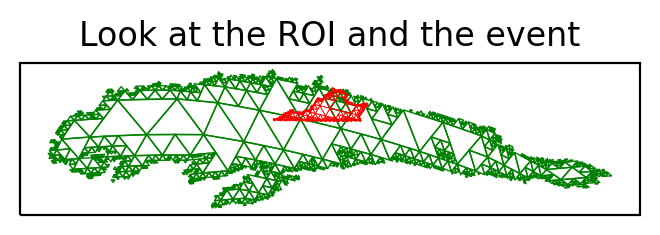

In [24]:
usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(4,4), dpi=200
    ,subplot_kw=plot_options))

dissolved_event.plot(ax=usr_figax.ax,color='g',lw=0.5)
roi.plot(ax=usr_figax.ax,color='r',lw=0.25)

plt.title('Look at the ROI and the event')
plt.show()

del usr_figax

In [58]:
over_roi.timestamp.min()

Timestamp('2021-01-25 09:00:00')

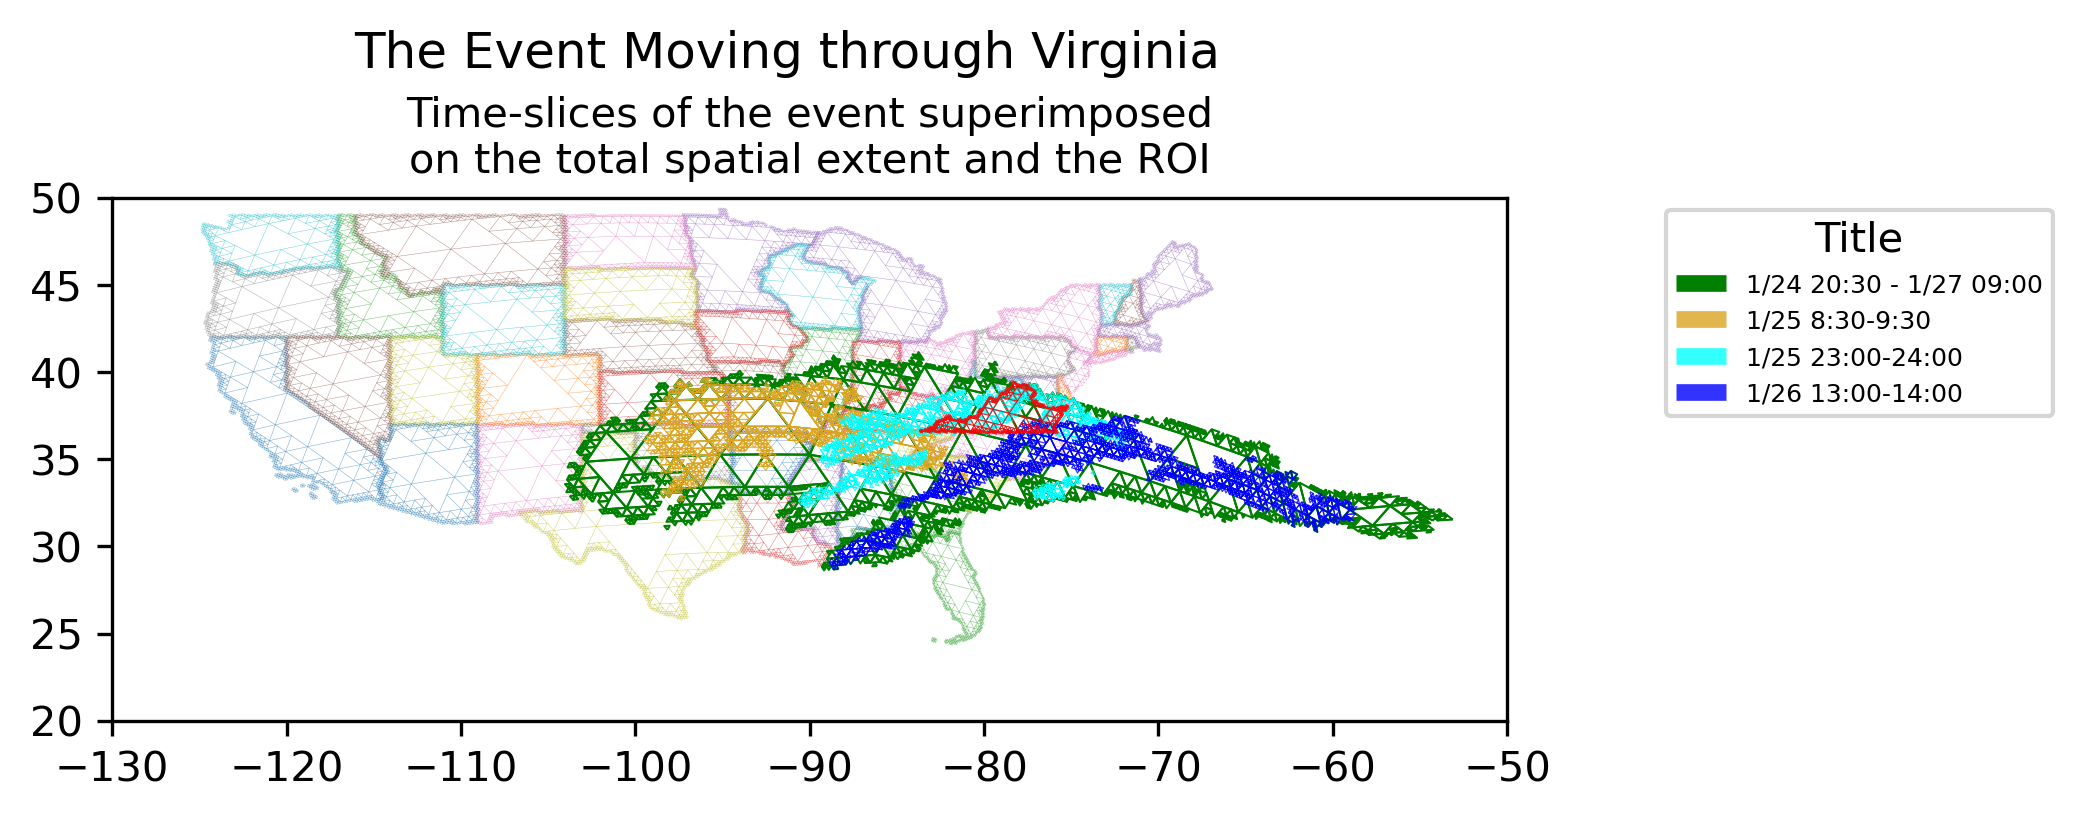

In [92]:
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot()

ax.set_xlim(-130, -65+15)
ax.set_ylim(20, 50)

states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4)

dissolved_sids = event_17.stare_dissolve()
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])

trixels = dissolved_event.make_trixels()
dissolved_event.set_trixels(trixels, inplace=True)

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='g', label='1/24 20:30 - 1/27 09:00')

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-25 08:30:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-25 09:30:00')))]
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='goldenrod',alpha=0.8,label='1/25 8:30-9:30')

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-25 23:00:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-26 00:00:00')))]
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='cyan',alpha=0.8,label='1/25 23:00-24:00')

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-26 13:00:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-26 14:00:00')))]
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='b',alpha=0.8,label='1/26 13:00-14:00')

# event_17.plot(ax=ax, zorder=1, linewidth=0.1)

roi.plot(ax=ax, zorder=4, color='r', linewidth=0.2,alpha=0.7)

leg = plt.legend(bbox_to_anchor=(0.2,1),markerscale=20,title='Title',prop={'size': 4})
for l in leg.get_lines():
    l.set_linewidth(4)

plt.suptitle('The Event Moving through Virginia',fontsize=12)
plt.title('Time-slices of the event superimposed\non the total spatial extent and the ROI',fontsize=10)
plt.show()

del fig,ax

In [25]:
# Take advantage of the fact that the resolution is all finer than 4 and 4 is the size of the pods.
print(mnmx(dissolved_event.sids.values[0] & 31 ))
dissolved_event_sids=starepandas.STAREDataFrame(sids=numpy.unique(pystare.spatial_clear_to_resolution(pystare.spatial_coerce_resolution(dissolved_event.sids.values[0],4)))).hex()

(5, 9)


In [26]:
b = numpy.unique(pystare.spatial_clear_to_resolution(pystare.spatial_coerce_resolution(dissolved_event.sids.values[0],4)))

## Check that the pods we're loading cover the event

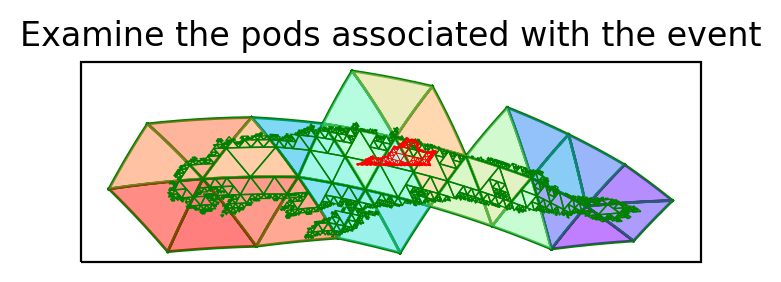

In [27]:
usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(4,4), dpi=200
    ,subplot_kw=plot_options))

dissolved_event.plot(ax=usr_figax.ax,color='g',lw=0.5)
roi.plot(ax=usr_figax.ax,color='r',lw=0.25)
# b = dissolved_event_sids

zs = numpy.asarray(range(1*len(b)),dtype=float)/(1.0*len(b))
tripcolor_alpha = 0.5
cd_cmap=plt.cm.get_cmap('rainbow')

usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(
    b,usr_figax,rasterized=True,plot_options=plot_options,color='g'
    ,show_fig=False
    ,face_zs = zs
    ,face_cmap   = cd_cmap
    ,face_alpha  = tripcolor_alpha
    ,face_vmin   = min(zs)
    ,face_vmax   = max(zs)
    ,face_shading = 'gouraud'
    ,verbose = False
)
plt.title('Examine the pods associated with the event')
plt.show()

del usr_figax

## Set the regex pattern for the pods to subset

In [28]:
# The current prototype STARE-PODS uses only STARE/HTM (spatial) indexing, not temporal
# pattern='S1.1C.F16.*2021012[4567].*'
# pattern='S1.1C.F16.*20210124.*'
pattern='S1\.1C..*\.2021012[4567].*'

## Set the STARE region to read from pods

In [29]:
start2 = datetime.datetime.now()

In [30]:
# sids_=['0x2220000000000004']

# Load all of the data from the event
sids_=dissolved_event_sids

In [31]:
s1 = starepandas.read_pods(pod_root='/tablespace/xcal/starepods/', sids=sids_, pattern=pattern, add_podname=True)

In [32]:
print('{:8} {}'.format('Platform','IFOVs loaded'))
print('-------- ------------')
for k in ['F16','F17','F18','NOAA20','NPP']:
    print('{:8} {}'.format(k,s1[s1.pod.str.contains(k)].size))

Platform IFOVs loaded
-------- ------------
F16      1515288
F17      1537400
F18      1518640
NOAA20   1129296
NPP      1152384


In [33]:
s1.set_sids('stare',inplace=True)
s1.set_trixels(s1.make_trixels(n_workers=50, wrap_lon=False),inplace=True)
# s1.split_antimeridian(inplace=True)

In [34]:
s1['level']=2**(10-pystare.spatial_resolution(s1['stare']))

In [35]:
s1.set_geometry(geopandas.points_from_xy(s1.lon, s1.lat, crs=4326), inplace=True)
# s1_.set_trixels(s1_.make_trixels(n_workers=600), inplace=True)

In [36]:
s1.reset_index(inplace=True)

## Restrict (subset) the data to the ROI

In [37]:
# mask = s1.stare_intersects(dissolved_event['sids'].iloc[0])

# Set the ROI to the entire event
mask_name = "ROI=Event"
mask = s1.stare_intersects(dissolved_event.sids.values[0])

# Set the ROI to the roi (state) set above
# mask_name = roi_name
# mask = s1.stare_intersects(roi_sids)

s1_ = s1.reset_index()[mask]
mnmx(pystare.spatial_resolution(s1_.stare))

(7, 9)

In [38]:
timings.add('XCAL initial load and restriction',datetime.datetime.now()-start2)

XCAL initial load and restriction 0:01:19.653429


In [39]:
# bounds = roi.bounds.values.flatten(); bounds

In [40]:
# bbox = [bounds[0],bounds[2],bounds[1],bounds[3]]; bbox

## Examine the XCAL data loaded from the PODS and subsetted to the mask

F16.SSMIS      IFOVs: 349557
F17.SSMIS      IFOVs: 365378
F18.SSMIS      IFOVs: 344266
NOAA20.ATMS    IFOVs: 191516
NPP.ATMS       IFOVs: 188006


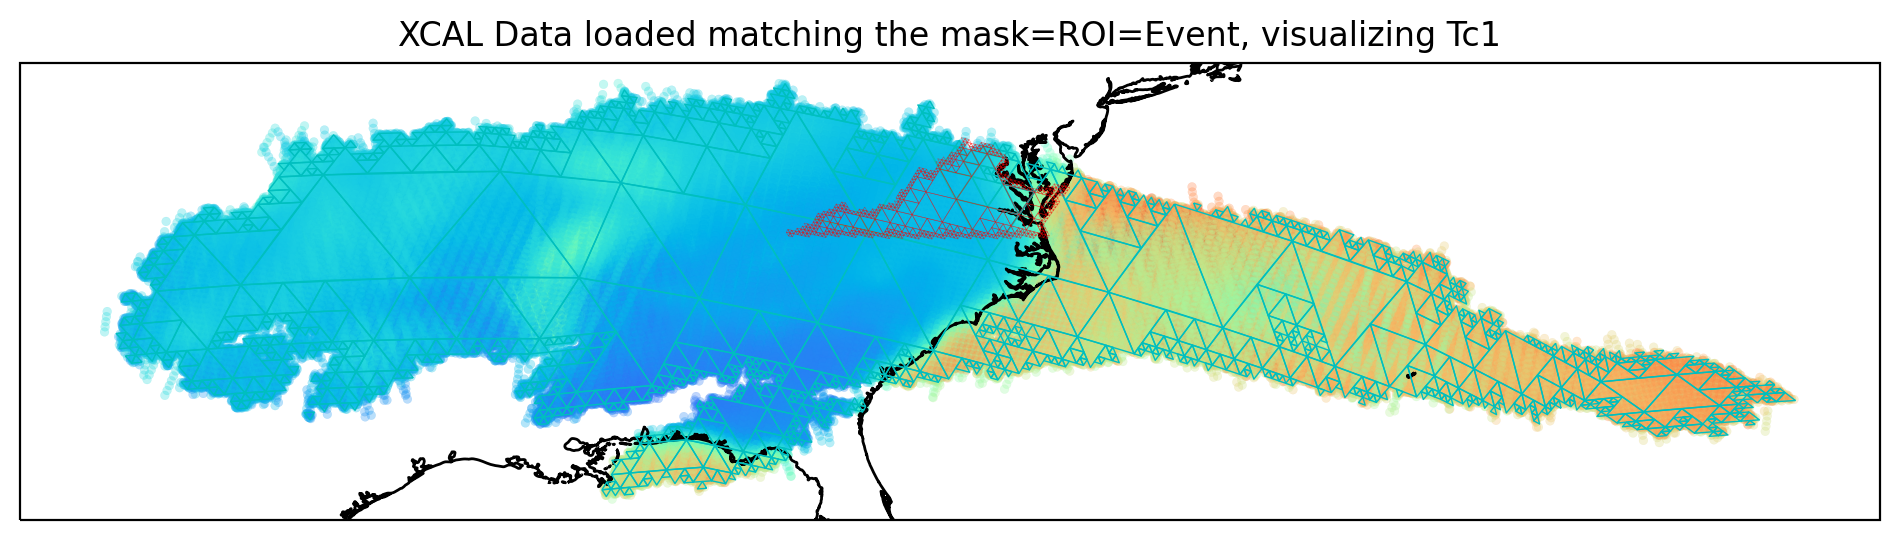

In [41]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
# ax.set_extent([-82.5, -72.5, 35, 40])
# ax.set_extent([-179, -50, 90, 10])
#ax.set_extent(bbox)

# roi.boundary.plot(ax=ax, transform=transf, lw=0.5, color='r')

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16.SSMIS':'r'
     ,'F17.SSMIS':'g'
     ,'F18.SSMIS':'b'
     ,'NOAA20.ATMS':'y'
     ,'NPP.ATMS':'c'
}

var_name='Tc1'

vmin = min(s1_[var_name])
vmax = max(s1_[var_name])

import pandas

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s_.iloc[numpy.where((over_roi.timestamp.min() <= s_.timestamp) & (s_.timestamp <= over_roi.timestamp.max()))]
    l  = 1
    print('{:14} IFOVs: {}'.format(k,s_.size))
    if s_.size > 0:
        #++ 
        
#        s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=4*s_['level'], alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=10*8*0.125, alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        # s_.plot(ax=ax, trixels=False, lw=0.1, transform=transf, markersize=1, alpha=0.5, color=v)

        # b = [4282096412885254152]
        # b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False)
        
dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='c')
roi.plot(ax=ax, zorder=3, linewidth=0.2, color='r',alpha=0.5)

plt.title('XCAL Data loaded matching the mask=%s, visualizing %s'%(mask_name,var_name))
plt.show()
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

## Zoom in to see some detail

F16.SSMIS      IFOVs: 349557
F17.SSMIS      IFOVs: 365378
F18.SSMIS      IFOVs: 344266
NOAA20.ATMS    IFOVs: 191516
NPP.ATMS       IFOVs: 188006


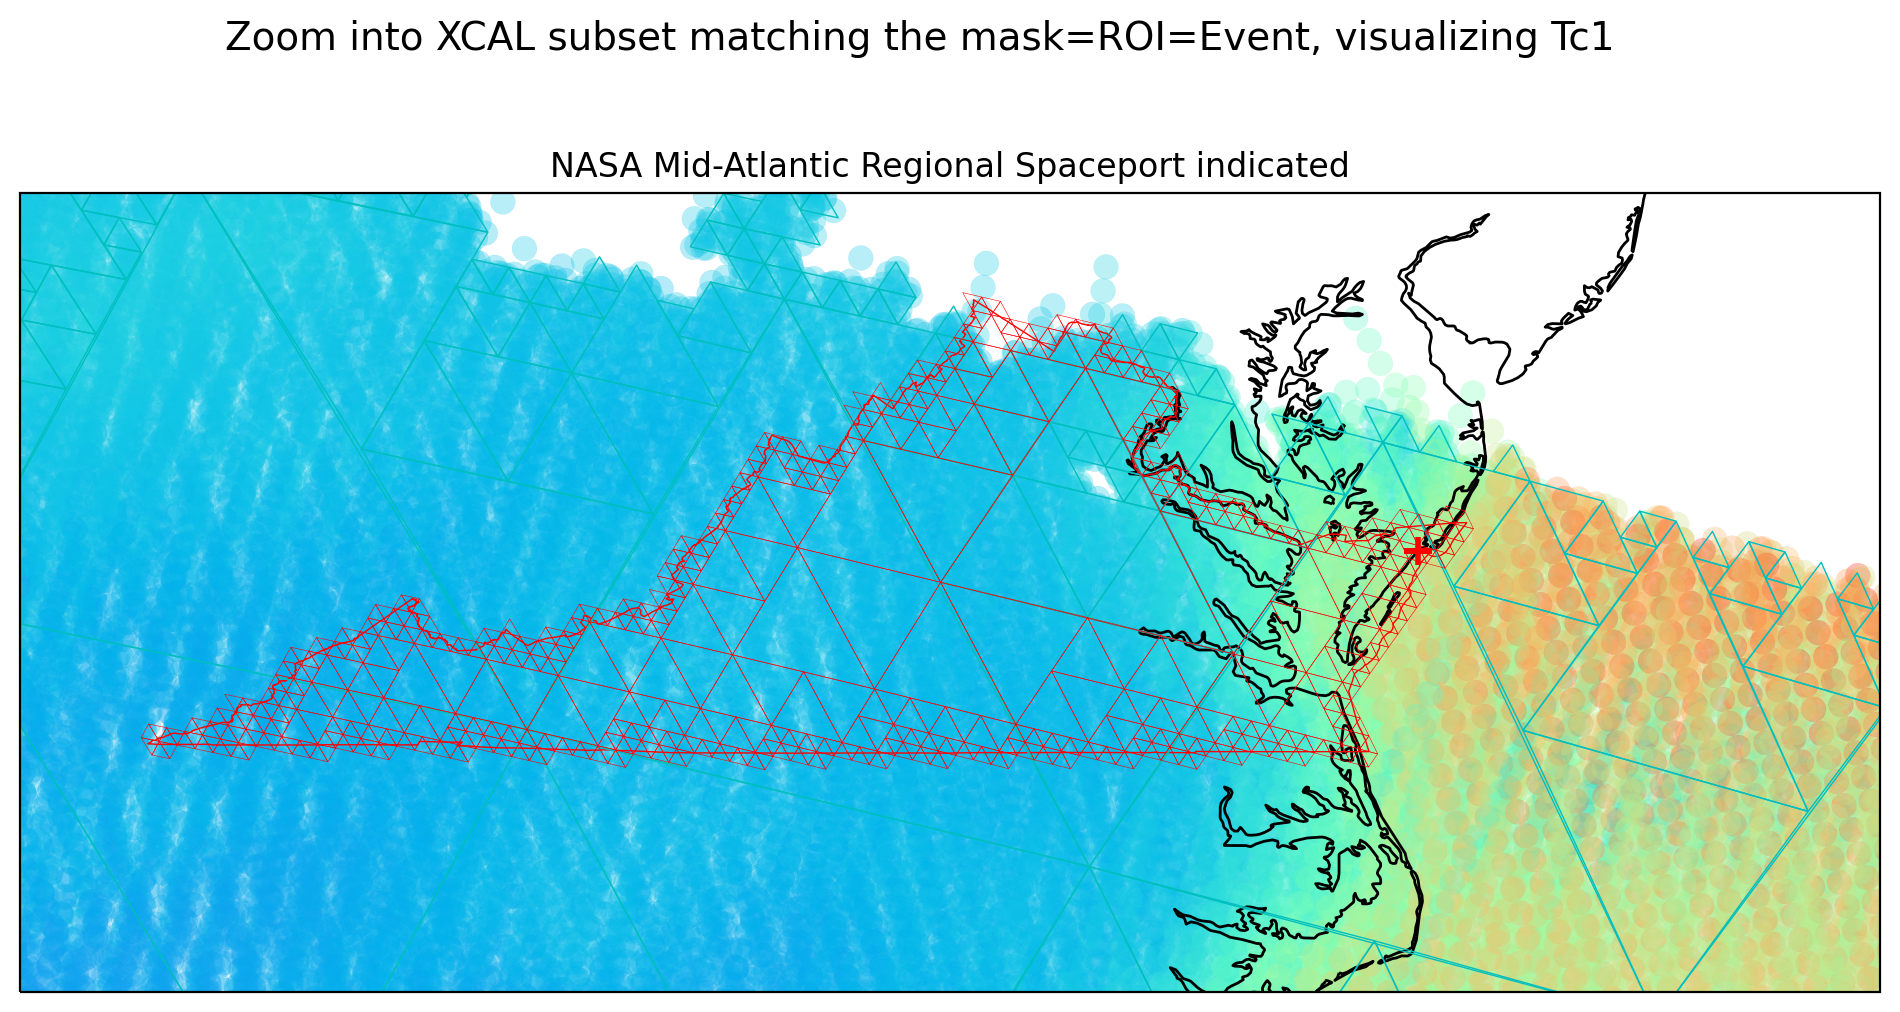

In [42]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])

# Virginia
# ax.set_extent([-84.5, -72.5, 35, 40])

if True:
    # Virginia
    extent = [-84.5, -72.5, 35, 40]
    lat0=37.5
    lon0=-77.5
    ax.set_extent(extent)
    delta=50
    marker_scale = (12.0/(2*delta))
    extent_name  = 'Virginia'
    legend_anchor = (0.79,0.6)
    legend_marker_scale = 1

# ax.set_extent([-179, -50, 90, 10])
#ax.set_extent(bbox)

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

colors={
    'F16.SSMIS':'r'
    ,'F17.SSMIS':'g'
    ,'F18.SSMIS':'b'
    ,'NOAA20.ATMS':'y'
    ,'NPP.ATMS':'c'
}

var_name = 'Tc1'

vmin = min(s1_[var_name])
vmax = max(s1_[var_name])

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s_.iloc[numpy.where((over_roi.timestamp.min() <= s_.timestamp) & (s_.timestamp <= over_roi.timestamp.max()))]
    l  = 1
    print('{:14} IFOVs: {}'.format(k,s_.size))
    if s_.size > 0:
        #++ 
        # s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=10*s_['level'], alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=10*8, alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        # s_.plot(ax=ax, trixels=False, lw=0.1, transform=transf, markersize=1, alpha=0.5, color=v)

        # b = [4282096412885254152]
        # b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False)
        
# dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='r')
# roi.plot(ax=ax,zorder=2,linewidth=0.4,color='k')
roi.boundary.plot(ax=ax, transform=transf, lw=0.5, color='r')

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='c')
roi.plot(ax=ax, zorder=3, linewidth=0.2, color='r')

lat_mars=37.843333
lon_mars=-75.478056
plt.scatter([lon_mars],[lat_mars],s=100,transform=transf,marker='+',color='r',lw=2,zorder=4)

plt.suptitle('Zoom into XCAL subset matching the mask=%s, visualizing %s'%(mask_name,var_name),fontsize=14)
plt.title('NASA Mid-Atlantic Regional Spaceport indicated',fontsize=12)

plt.show()
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

## Look at the IFOVs colored according to their source platform

F16.SSMIS      IFOVs: 349557
F17.SSMIS      IFOVs: 365378
F18.SSMIS      IFOVs: 344266
NOAA20.ATMS    IFOVs: 191516
NPP.ATMS       IFOVs: 188006

Colors

F16.SSMIS      r
F17.SSMIS      g
F18.SSMIS      b
NOAA20.ATMS    y
NPP.ATMS       c


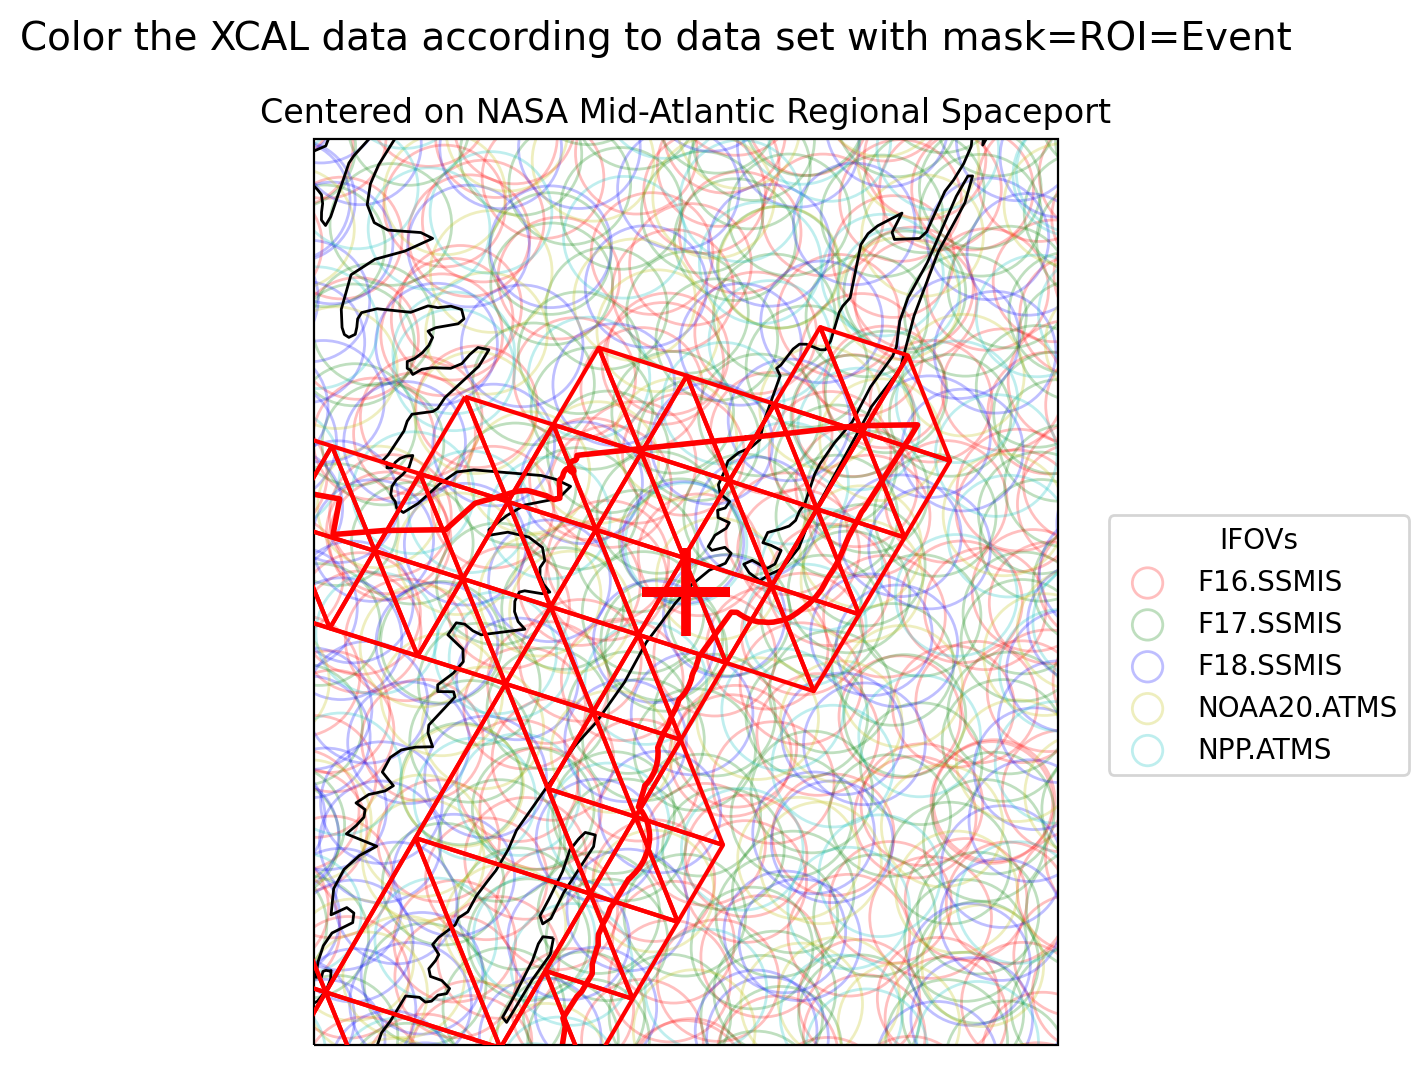

In [54]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
# ax.set_extent([-82.5, -72.5, 35, 40])

# Virginia
# ax.set_extent([-84.5, -72.5, 35, 40])
# marker_scale = 1

if False:
    # Virginia
    extent = [-84.5, -72.5, 35, 40]
    lat0=37.5
    lon0=-77.5
    ax.set_extent(extent)
    delta=50
    marker_scale = (12.0/(2*delta))
    extent_name  = 'Virginia'
    legend_anchor = (0.79,0.6)
    legend_marker_scale = 1
    
# CONUS
# [-179, -50, 90, 10]

if True:
    # NASA Mid-Atlantic Regional Spaceport
    # geo:37.843333,-75.478056
    lat0=37.843333
    lon0=-75.478056
    delta=0.5
    extent = [lon0-delta, lon0+delta, lat0-delta, lat0+delta]
    ax.set_extent(extent)
    marker_scale = (12.0/(2*delta))
    extent_name  = 'NASA Mid-Atlantic Regional Spaceport'
    legend_anchor = (1.05,0.6)
    legend_marker_scale = 0.25

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16.SSMIS':'r'
    ,'F17.SSMIS':'g'
    ,'F18.SSMIS':'b'
    ,'NOAA20.ATMS':'y'
    ,'NPP.ATMS':'c'
}

#dissolved_event.plot(ax=ax, zorder=2, linewidth=0.3, color='r')
roi.boundary.plot(ax=ax, transform=transf, lw=2, color='r')
roi.plot(ax=ax, zorder=3, linewidth=1.5, color='r')

for i, (k,v) in enumerate(colors.items()):
#    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s_.iloc[numpy.where((over_roi.timestamp.min() <= s_.timestamp) & (s_.timestamp <= over_roi.timestamp.max()))]
    l  = 1
    print('{:14} IFOVs: {}'.format(k,s_.size))
    if s_.size > 0:
        #++ 
        # s_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=2*s_['level'], alpha=0.4, cmap='rainbow_r')
        s_.plot(ax=ax, trixels=False, lw=1, transform=transf, markersize=160*marker_scale, alpha=0.25, edgecolor=v, facecolor='none',label=k)

        # b = [4282096412885254152]
        b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False,lw=0.2)

# usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(pystare.from_latlon([37.5],[-77.5],9),usr_figax,rasterized=True,plot_options=plot_options,color='r',show_fig=False,lw=2) # Richmond
# usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(pystare.from_latlon([37.475891],[-76.728297],9),usr_figax,rasterized=True,plot_options=plot_options,color='r',show_fig=False,lw=2) # Bland's Folly
# usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(pystare.from_latlon([lat0],[lon0],9),usr_figax,rasterized=True,plot_options=plot_options,color='k',show_fig=False,lw=3) # NASA MARS

plt.suptitle('Color the XCAL data according to data set with mask=%s'%mask_name,fontsize=14)
plt.title('Centered on %s'%extent_name,fontsize=12)

leg = plt.legend(bbox_to_anchor=legend_anchor,markerscale=legend_marker_scale,title='IFOVs')

# for l in leg.get_lines():
#    l.set_linewidth(40)

plt.scatter([lon0],[lat0],s=1000,transform=transf,marker='+',color='r',lw=3.5,zorder=4)

print('\nColors\n')
for i, (k,v) in enumerate(colors.items()):
    print('{:14} {}'.format(k,v))
plt.show()
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

In [ ]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
# ax.set_extent([-82.5, -72.5, 35, 40])

# Virginia
# ax.set_extent([-84.5, -72.5, 35, 40])
# marker_scale = 1

if True:
    # Virginia
    extent = [-84.5, -72.5, 35, 40]
    lat0=37.5
    lon0=-77.5
    ax.set_extent(extent)
    delta=50
    marker_scale = 4*(12.0/(2*delta))
    extent_name  = 'Virginia'
    legend_anchor = (0.79,0.6)
    legend_marker_scale = 1
    
# CONUS
# [-179, -50, 90, 10]

if False:
    # NASA Mid-Atlantic Regional Spaceport
    # geo:37.843333,-75.478056
    lat0=37.843333
    lon0=-75.478056
    delta=0.5
    extent = [lon0-delta, lon0+delta, lat0-delta, lat0+delta]
    ax.set_extent(extent)
    marker_scale = (12.0/(2*delta))
    extent_name  = 'NASA Mid-Atlantic Regional Spaceport'
    legend_anchor = (1.05,0.6)
    legend_marker_scale = 0.25

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16.SSMIS':'r'
    ,'F17.SSMIS':'g'
    ,'F18.SSMIS':'b'
    ,'NOAA20.ATMS':'y'
    ,'NPP.ATMS':'c'
}

#dissolved_event.plot(ax=ax, zorder=2, linewidth=0.3, color='r')
roi.boundary.plot(ax=ax, transform=transf, lw=0.75, color='r')
roi.plot(ax=ax, zorder=3, linewidth=1, color='r')

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s_.iloc[numpy.where((over_roi.timestamp.min() <= s_.timestamp) & (s_.timestamp <= over_roi.timestamp.max()))]
    l  = 1
    print('{:14} IFOVs: {}'.format(k,s_.size))
    if s_.size > 0:
        #++ 
        # s_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=2*s_['level'], alpha=0.4, cmap='rainbow_r')
        s_.plot(ax=ax, trixels=False, lw=1, transform=transf, markersize=160*marker_scale, alpha=0.25, edgecolor=v, facecolor='none',label=k)

        # b = [4282096412885254152]
        b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False,lw=0.2)

# usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(pystare.from_latlon([37.5],[-77.5],9),usr_figax,rasterized=True,plot_options=plot_options,color='r',show_fig=False,lw=2) # Richmond
# usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(pystare.from_latlon([37.475891],[-76.728297],9),usr_figax,rasterized=True,plot_options=plot_options,color='r',show_fig=False,lw=2) # Bland's Folly
# usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(pystare.from_latlon([lat0],[lon0],9),usr_figax,rasterized=True,plot_options=plot_options,color='r',show_fig=False,lw=2) # NASA MARS

plt.suptitle('Color the XCAL data according to data set with mask=%s'%mask_name,fontsize=14)
plt.title('Centered on %s'%extent_name,fontsize=12)

plt.legend(bbox_to_anchor=legend_anchor,markerscale=legend_marker_scale,title='IFOVs',lw=2,alpha=1)

plt.scatter([-75.478056],[37.843333],s=100,transform=transf,marker='+',color='w',lw=1,zorder=4)

print('\nColors\n')
for i, (k,v) in enumerate(colors.items()):
    print('{:14} {}'.format(k,v))
plt.show()
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

In [ ]:
hex(pystare.from_latlon([37.5],[77.5],9)[0])

## Now focus on subsetting with mask=ROI (e.g. VA, AL, etc.)

In [ ]:
start3 = datetime.datetime.now()

In [ ]:
# mask = s1.stare_intersects(dissolved_event['sids'].iloc[0])

# Set the ROI to the entire event
# mask_name = "ROI=Event"
# mask = s1.stare_intersects(dissolved_event.sids.values[0])

# Set the ROI to the roi (state) set above
mask_name = roi_name
mask = s1.stare_intersects(roi_sids)

s1_ = s1.reset_index()[mask]
mnmx(pystare.spatial_resolution(s1_.stare))

In [ ]:
timings.add('XCAL remask to smaller ROI',datetime.datetime.now()-start3)

In [ ]:

# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
# ax.set_extent([-82.5, -72.5, 35, 40])
# ax.set_extent([-179, -50, 90, 10])
#ax.set_extent(bbox)

# roi.boundary.plot(ax=ax, transform=transf, lw=0.5, color='r')

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16.SSMIS':'r'
    ,'F17.SSMIS':'g'
    ,'F18.SSMIS':'b'
    ,'NOAA20.ATMS':'y'
    ,'NPP.ATMS':'c'
}

var_name='Tc1'

vmin = min(s1_[var_name])
vmax = max(s1_[var_name])

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s_.iloc[numpy.where((over_roi.timestamp.min() <= s_.timestamp) & (s_.timestamp <= over_roi.timestamp.max()))]
    l  = 1
    print(k,' size: ',s_.size)
    if s_.size > 0:
        #++ 
        # s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=4*s_['level'], alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=10*8*0.125, alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        # s_.plot(ax=ax, trixels=False, lw=0.1, transform=transf, markersize=1, alpha=0.5, color=v)

        # b = [4282096412885254152]
        # b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False)
        
dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='c')
roi.plot(ax=ax, zorder=3, linewidth=0.2, color='r',alpha=0.5)

plt.title('XCAL Data loaded matching the mask=%s, visualizing %s'%(mask_name,var_name))
plt.show()
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

In [ ]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
ax.set_extent([-84.5, -72.5, 35, 40])
# ax.set_extent([-179, -50, 90, 10])
#ax.set_extent(bbox)

# roi.boundary.plot(ax=ax, transform=transf, lw=0.5, color='r')

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16.SSMIS':'r'
    ,'F17.SSMIS':'g'
    ,'F18.SSMIS':'b'
    ,'NOAA20.ATMS':'y'
    ,'NPP.ATMS':'c'
}

var_name = 'Tc1'

vmin = min(s1_[var_name])
vmax = max(s1_[var_name])

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s_.iloc[numpy.where((over_roi.timestamp.min() <= s_.timestamp) & (s_.timestamp <= over_roi.timestamp.max()))]
    l  = 1
    print(k,' size: ',s_.size)
    if s_.size > 0:
        #++ 
        # s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=10*s_['level'], alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=10*8, alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        # s_.plot(ax=ax, trixels=False, lw=0.1, transform=transf, markersize=1, alpha=0.5, color=v)

        # b = [4282096412885254152]
        # b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False)
        
# dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='r')
# roi.plot(ax=ax,zorder=2,linewidth=0.4,color='k')

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='c')
roi.plot(ax=ax, zorder=3, linewidth=0.2, color='r')

plt.title('Zoom into XCAL subset to the mask=%s, visualizing %s'%(mask_name,var_name))
plt.show()
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

In [ ]:
# proj = cartopy.crs.NearsidePerspective(central_longitude=-110, central_latitude=20)

usr_figax = psplot.FigAxContainer(
    plt.subplots(figsize=(12,6), dpi=200
    ,subplot_kw=plot_options))

transf = plot_options['transform']

ax = usr_figax.ax
    
ax.coastlines()
# ax.set_extent([-125, -55, 24, 50])
# ax.set_extent([-75, -65, 32, 42])
ax.set_extent([-84.5, -72.5, 35, 40])
# ax.set_extent([-179, -50, 90, 10])
#ax.set_extent(bbox)

# roi.boundary.plot(ax=ax, transform=transf, lw=0.5, color='r')

#++ s1_.plot(ax=ax, trixels=True, lw=0.1, color='b', transform=transf, markersize=1)
# s1_.plot(ax=ax, column='Tc1', trixels=False, lw=0.1, transform=transf, markersize=10*s1_['level'], alpha=0.125, cmap='rainbow_r')

# s1_a = s1_[9540:9550]

colors={
    'F16.SSMIS':'r'
    ,'F17.SSMIS':'g'
    ,'F18.SSMIS':'b'
    ,'NOAA20.ATMS':'y'
    ,'NPP.ATMS':'c'
}

var_name = 'Tc1'

vmin = min(s1_[var_name])
vmax = max(s1_[var_name])

for i, (k,v) in enumerate(colors.items()):
    s_ = s1_[s1_.pod.str.contains(k)]
    s_ = s_.iloc[numpy.where((over_roi.timestamp.min() <= s_.timestamp) & (s_.timestamp <= over_roi.timestamp.max()))]
    l  = 1
    print(k,' size: ',s_.size)
    if s_.size > 0:
        #++ 
        # s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=10*s_['level'], alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        # s_.plot(ax=ax, column=var_name, trixels=False, lw=0.1, transform=transf, markersize=10*8, alpha=0.3, cmap='rainbow_r',vmin=vmin,vmax=vmax)
        # s_.plot(ax=ax, trixels=False, lw=0.1, transform=transf, markersize=1, alpha=0.5, color=v)    
        s_.plot(ax=ax, trixels=False, lw=1, transform=transf, markersize=160*marker_scale, alpha=0.25, edgecolor=v, facecolor='none',label=k)

        # b = [4282096412885254152]
        # b=s_.stare
        # usr_figax, sivs_cache, sivs_triang = psplot.hello_plot(b,usr_figax,rasterized=True,plot_options=plot_options,color=v,show_fig=False)
        
# dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='r')
# roi.plot(ax=ax,zorder=2,linewidth=0.4,color='k')

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='c')
roi.plot(ax=ax, zorder=3, linewidth=0.2, color='r')

plt.legend(bbox_to_anchor=legend_anchor,markerscale=legend_marker_scale,title='IFOVs',linewidth=2,alpha=1)

plt.suptitle('Color the XCAL data according to data set with mask=%s'%mask_name,fontsize=14)
plt.title('Centered on %s'%extent_name,fontsize=12)

plt.show()
        
# Add a column with the resolution level to set the markersize.
del usr_figax,ax

In [ ]:
timings.add('Total run time for XCAL subsetting and visualizations',datetime.datetime.now()-start1)

## Timing summary

In [ ]:
timings.print_report(fmt="{:58}: {:>6.2f}")